# Data Preparation 

This notebook discuss how we have manually labelled spiral galaxies using an [online GUI](http://edd.ifa.hawaii.edu/inclination/) in a collaborative project. Users of the interface are asked to situate a target galaxy within a lattice of galaxies with established inclinations. In this graphical interface, we use the colorful images provided [SDSS](https://www.sdss.org/) as well as the `g`, `r` and `i` band images generated for our photometry program. These latter are presented in black-and-white after re-scaling by the `asinh` function to differentiate more clearly the internal structures of galaxies. The inclination of standard galaxies were initially measured based on their `I`-band axial ratios.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "http://edd.ifa.hawaii.edu/inclination/helpics/drag_drop.png")

Each galaxy is compared with the standard galaxies in two steps. First, the user locates the galaxy among nine standard galaxies sorted by their inclinations ranging between 45 and 90 degrees in increments of `5` degrees. 
In step two, the same galaxy is compared with nine other standard galaxies whose inclinations are one degree apart and cover the 5 degrees interval found in the first step. At the end, the inclination is calculated by averaging the inclinations of the standard galaxies on the left/right-side of the target galaxy. 

In [2]:
Image(url= "http://edd.ifa.hawaii.edu/inclination/helpics/trash.png")

We take the following precautions to minimize user dependant and independent biases:

- We round the resulting inclinations to the next highest or smallest integer values chosen randomly. 
- At each step, standard galaxies are randomly drawn with an option for users to change them randomly to verify their work or to compare galaxies with similar structures. 
- To increase the accuracy of the results, we catalog the median of at least **three** different measurements preformed by different users. 
- Users may **reject** galaxies for various reasons and leave comments with the aim of avoiding dubious cases.

The uncertainties on the measured inclinations are estimated based on the statistical scatter in the reported values by different users.

A more detailed discussions of these measurements and their uncertainties are presented in these papers: 

- Global Attenuation in Spiral Galaxies in Optical and Infrared Bands (**Journal ref:** Kourkchi et al.,2019, ApJ, 884, 82, [arXiv:1909.01572](https://arxiv.org/pdf/1909.01572))
- Cosmicflows-4: The Catalog of ~10000 Tully-Fisher Distances (**Journal ref:** Kourkchi et al., 2020, ApJ, 902, 145, [arXiv:2009.00733](https://arxiv.org/pdf/2009.00733)) 

## Data Product

[Galaxy Inclination Zoo](http://edd.ifa.hawaii.edu/inclination/) stores all of of the outputs in a `SQL` database. Each time a user sorts a galaxy in the GUI, the database gets updated.

We have devided the users of the project into two groups:
1. Undergraduate students of the Unviersity of Hawaii at Manoa
2. Citizen scientists and astronomy enthusiasts who helps us in this project

The output tables of the SQL database have been stored in two tables:
- `EDD_incNET_Manoa.20190524.txt` for the UH students
- `EDD_incNET_Guest.20190524.txt` for the guest users


In [88]:
import sys
import os
import subprocess
import glob
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from optparse import OptionParser
from PIL import Image#, ImageTk
from subprocess import Popen, PIPE
import matplotlib.patches as patches
import scipy.misc as scimisc
import pandas as pd

## Output format

- Each user is identified by his/her email address. 
- `inc` is the mesured inclnation at each instance
- `pgcID` is the ID of the sorted target galaxy whose inclination has been evaluated
- `pgcID1` and `pgcID2` are the ID of the galaxies that are located in the left and right of the target galaxy by user
- `flag` = 0 if galaxy has been accepted, = 1 if user has decided to reject the galaxy
- `email` is the user email address
- `note` holds the optional notes left by users
- Other columns are self explanatory. They hold some data logs that are produced by user. If a user decide to reject a galaxy for specific reasons, they would be recorded in the relevant columns.

In [89]:
Manoa = pd.read_csv('EDD_incNET_Manoa.20190524.txt', delimiter='|')
Manoa.email = Manoa.apply(lambda x: ' '.join(x.email.split()), axis=1)  # removing extra spaces
Manoa.note = Manoa.apply(lambda x: ' '.join(x.note.split()), axis=1)

Guest = pd.read_csv('EDD_incNET_Guest.20190524.txt', delimiter='|')
Guest.email = Guest.apply(lambda x: ' '.join(x.email.split()), axis=1) 
Guest.note = Guest.apply(lambda x: ' '.join(x.note.split()), axis=1)

df_All = pd.concat([Manoa, Guest]) # .set_index('pgcID')

df_All.head()

,id,pgcID,inc,pgcID1,pgcID2,flag,not_sure,better_image,bad_TF,ambiguous,...,HI,face_on,not_spiral,multiple,note,email,inputTable,checkoutTime,checkinTime,ip
0,82359,34787,82.5,25423,2928,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:54:00,2019-05-24 15:55:53,73.131.231.15
1,82358,91449,90.0,36431,,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:53:30,2019-05-24 15:53:56,73.131.231.15
2,82357,2609142,85.5,71260,3332,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:50:27,2019-05-24 15:53:25,73.131.231.15
3,82356,53853,61.5,40507,50784,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:48:41,2019-05-24 15:50:00,73.131.231.15
4,82355,53842,90.0,1933,,0,0,0,0,0,...,0,0,0,0,,s.eftekharzadeh@gmail.com,sdss_finale_srh,2019-05-24 15:47:48,2019-05-24 15:48:35,73.131.231.15


In [97]:
df_incMedian = df_All[["pgcID", "inc", "flag", "face_on"]].groupby('pgcID').agg('median')

df_incMedian.head()

,inc,flag,face_on
pgcID,,,
-1,-1.0,0.0,0.0
2,52.5,0.0,0.0
4,85.5,0.0,0.0
12,81.5,0.0,0.0
16,65.5,0.0,0.0


Defining the supervisors of the project. If any of these supervisors rejects a galaxy (flag=1), the glaxy should be rejected regardless of the opinion of other users. If two supervisors contradict each other, the preference goes to RBT.

- R. B. Tully (has participated in the project via 2 email addresses)
- Ehsan Kourkchi (just one email address)

In [98]:
Keypeople_ehsan = ['ekourkchi@gmail.com']
Keypeople_brent = ['rbtully1@gmail.com', 'rtully@hawaii.edu']

In [103]:
df_ehsan = df[[True if email in Keypeople_ehsan else False for email in df.email.values]][["pgcID",'flag',"face_on"]]
# happens that a person has worked on a galaxy multiplt times
ehsan_flagMed = df_ehsan.groupby('pgcID').agg('median') 


df_brent = df[[True if email in Keypeople_brent else False for email in df.email.values]][["pgcID",'flag',"face_on"]]
brent_flagMed = df_brent.groupby('pgcID').agg('median')


df_super = ehsan_flagMed.join(brent_flagMed, how='outer', lsuffix='_ehsan', rsuffix='_brent')

# Brent's flag is prefered over Ehsan's
df_super['flag_super'] = df_super.apply(lambda x: x.flag_brent if ~np.isnan(x.flag_brent) else x.flag_ehsan, axis=1)
df_super['face_on_super'] = df_super.apply(lambda x: x.face_on_brent if ~np.isnan(x.face_on_brent) else x.face_on_ehsan, axis=1)


df_super.tail()

,flag_ehsan,face_on_ehsan,flag_brent,face_on_brent,flag_super,face_on_super
pgcID,,,,,,
6719913,1.0,0.0,NaN,NaN,1.0,0.0
6724044,1.0,1.0,NaN,NaN,1.0,1.0
6724069,0.0,0.0,NaN,NaN,0.0,0.0
6724508,1.0,0.0,0.0,0.0,0.0,0.0
6726345,1.0,1.0,NaN,NaN,1.0,1.0


## Labeling

First we define the status of each galaxy
- `A`: Accepted
- `F`: Face-on
- `J`: Rejected

Then we generate classification labels which is exactly the same as the status except for galaxies with accepted inclinations, where their inclination is used as label

In [126]:
df_final = df_incMedian.join(df_super, how='outer')

# Super flag is prefered over median flag that is generated from the work of all users
df_final['flag_final'] = df_final.apply(lambda x: x.flag_super if ~np.isnan(x.flag_super) else x.flag, axis=1)
df_final['face_on_final'] = df_final.apply(lambda x: x.face_on_super if ~np.isnan(x.face_on_super) else x.face_on, axis=1)


df_final = df_final[["inc", "flag_final", "face_on_final"]]

df_final['status'] = 'A'  # accepted

# Face-on
df_final['status'] = df_final.apply(lambda x: 'F' if x.face_on_final==1 else x.status, axis=1) 
# Rejected
df_final['status'] = df_final.apply(lambda x: 'J' if (x.face_on_final==0 and \
                                                      x.flag_final==0) else x.status, axis=1)   


df_final = df_final[["inc", "status"]].rename(columns={'inc':'inclination'})

# Generating claffication labels
# if inc<45 look at the status, if status is already accepted turn it into a rejection, because our online GUI
# has not been designed to sort galaxies with inclinations less than 45 degree
df_final['label'] = df_final.apply(lambda x: str(int(x.inclination)) if round(x.inclination)>=45 else \
                                                      x.status if x.status!='A' else 'J', axis=1)   

# taking care of negative galaxy IDs generated during the development stage of the online GUI and its database
df = df_final[df_final.index>0]   

df.head(10)

,inclination,status,label
pgcID,,,
2,52.5,J,52
4,85.5,J,85
12,81.5,J,81
16,65.5,J,65
18,47.0,J,47
55,78.0,J,78
68,55.5,J,55
70,90.0,J,90
76,68.5,J,68


# Data Exploration

Here is the distribution of the labels across the sample.
As seen, out of `19,907`, ~22% are rejected for various astronmical reasons and ~8% are face-on thus not acceptable for our original research purpose.

In [143]:
N = len(df)

print("# of galaxies in our original sample: ", N)

# of galaxies in our original sample:  19907


In [155]:
n_reject = len(df[df.label=='J'])
n_face   = len(df[df.label=='F'])

print("number of rejected galaxies: {} ({:.0f}%)".format(n_reject, n_reject/N*100.))
print("number of face-on galaxies: {} ({:.0f}%)".format(n_face, n_face/N*100.))

number of rejected galaxies: 4373 (22%)
number of face-on galaxies: 1667 (8%)


In our research, we purposfully favored more edge-on galaxies, to 

Text(0, 0.5, 'number of galaxies')

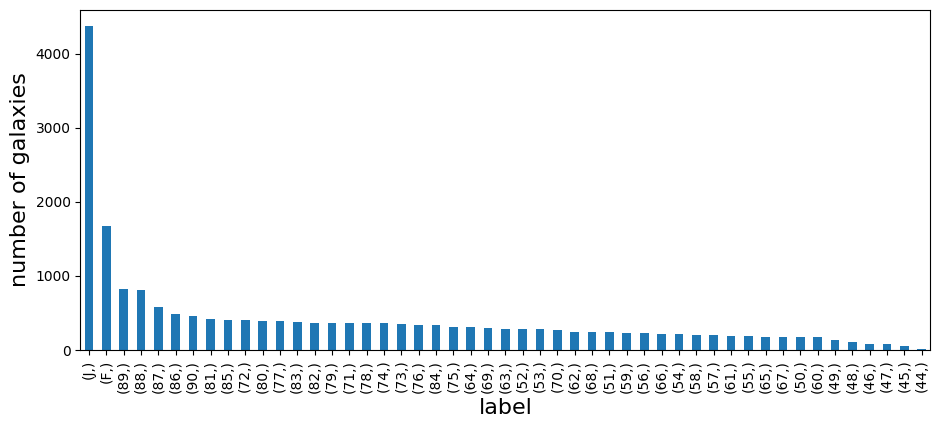

In [141]:
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

hist = df[["label"]].value_counts().plot(ax=ax, kind='bar')

ax.set_xlabel('label', fontsize=16)
ax.set_ylabel('number of galaxies', fontsize=16)